<a href="https://colab.research.google.com/github/stivenvilla1987/ProyectoFinal_RutaSchool/blob/master/SSA_seism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Análisis Multivariado de Señales Sismográficas

Tratamiento de Señales III

Facultad de Ingeniería

Universidad de Antioquia

2021

## Integrantes:

Stiven Alejandro Villa Vélez - CC: 1017145544.

Juan Esteban Agudelo Pérez - CC: 1152453746.

Jhonatan Dario Marin Jaramillo - CC: 1061370553.

##Pasos a seguir:
**1.** Filtrado de la señal

**2.** Análisis de espectro singular

**3.** Transformada corta de fourier (STFT)

**4.** Calculo de los siguientes descriptores:
* Energia
* Potencia máxima 
* Frecuencia de la potencia máxima
* Media
* Varianza
* Máximo del espectro
* Minimo del espectro


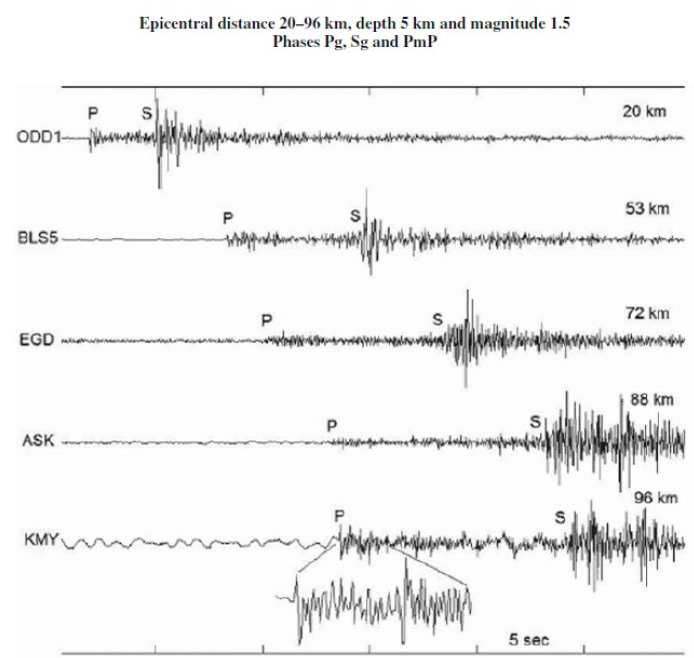

Los observatorios sismológicos clasifican las señales sísmicas de acuerdo a la diferencia de tiempo de arribo entre la onda P y la onda S, conocida como S-P. La S-P, es una indicación de la distancia que existe desde el punto donde se genera el sismo al punto donde se encuentra la estación que lo registra, es decir de la distancia epicentral. Dicho parámetro, aplicado a las señales registradas
por el OSQ permite definir tres tipos de sismos: local, caracterizado por tener una S-P menor a 20 s; regional cuya S-P varía entre 20 s y 180 s y telesismo, cuya S-P es mayor 180 s.

In [ ]:
!pip install pyts

     |████████████████████████████████| 2.5MB 4.3MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.decomposition import SingularSpectrumAnalysis
import scipy.io as sc

In [ ]:
data = sc.loadmat('sisTele.mat') # Señales de telesismos

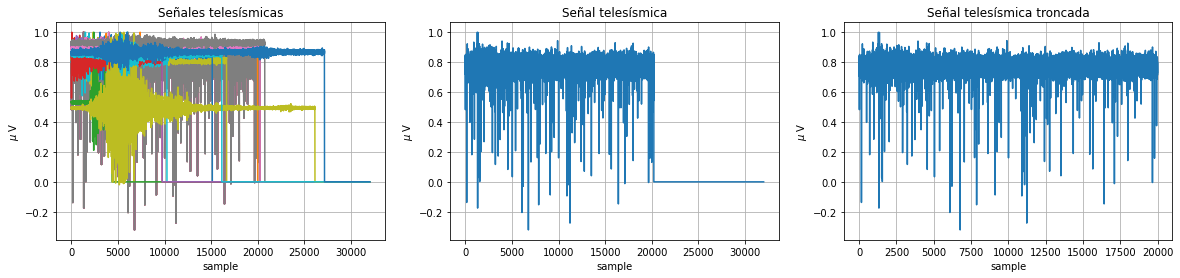

In [ ]:
# Vectores de las señales telesísmicas
Y = data['Y']  
fs = data['fs']

plt.figure(1,figsize=(20, 4))
plt.subplot(1,3,1)
plt.plot(Y.T) # transpuesta
plt.xlabel('sample')
plt.ylabel('$\mu$ V')
plt.title('Señales telesísmicas')
plt.grid()
sampleSignal = Y[0,:] # se extrae la primera señal del grupo de señales
plt.subplot(1,3,2)
plt.plot(sampleSignal)
plt.xlabel('sample')
plt.ylabel('$\mu$ V')
plt.title('Señal telesísmica')
plt.grid()
sampleSignal = Y[0,:20000] # se extrae solo una de las señales
plt.subplot(1,3,3)
plt.plot(sampleSignal)
plt.xlabel('sample')
plt.ylabel('$\mu$ V')
plt.title('Señal telesísmica troncada')
plt.grid()

En las gráficas anteriores encontramos algunas representaciones de señales telesísmicas, siendo la primera la representación de las 21 señales de estudio en este notebook, la segunda la representación de una sola señal y la tercera la representación de la mismsa señal anterior pero de forma troncada en 20000 muestras

Con las señales anteriores se construirá su correspondiente matriz de descriptores para tratar de encontrar aquellos que caractericen de la mejor manera el grupo al cual estas pertenecen.

Tambien se puede observar que estan señales están completadas con ceros despúes de cierto punto para poder garantizar que todas tengan una longitud uniforme y esto haga más facil su análisis

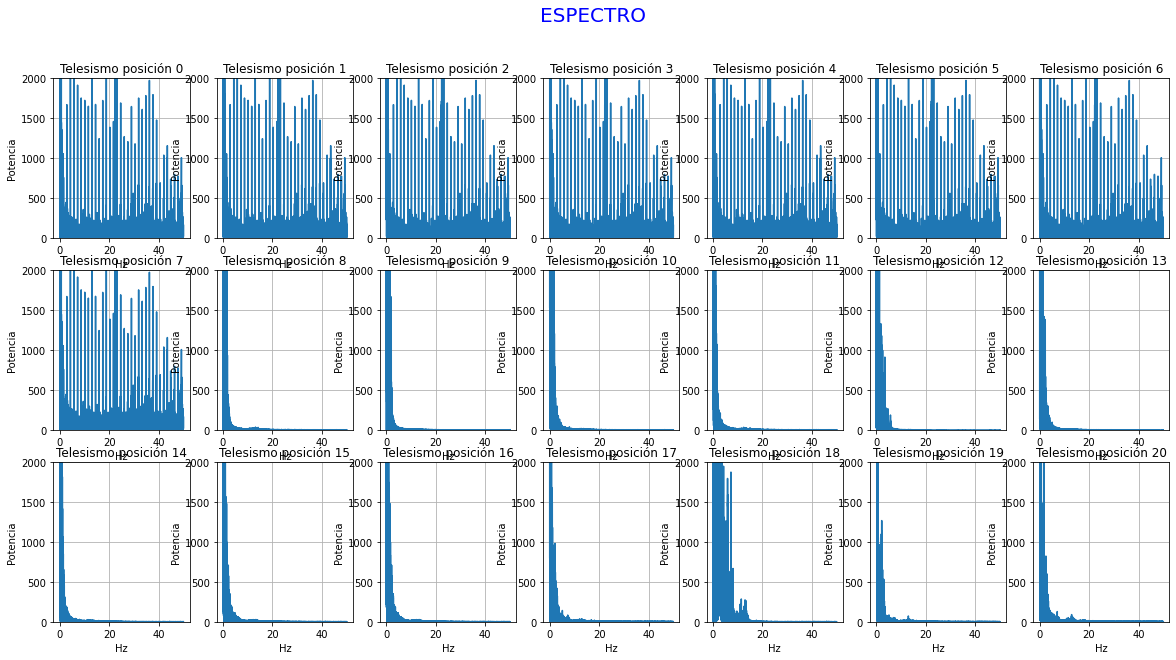

In [ ]:
#Transformada de Fourier de las 21 señales telesísmicas

for i in range(21):
  y= Y[i,:]
  plt.figure(1,figsize=(20, 10))
  plt.subplot(3, 7, i+1)
  X = np.fft.fft(y)
  X_pow = np.abs(X) ** 2
  N = len(y)
  f_pos = np.arange(0, fs / 2, step=fs / N)
  plt.plot(f_pos, X_pow[:(N // 2)])
  plt.ylim([0,2000])
  plt.grid(True)
  plt.xlabel("Hz")
  plt.ylabel("Potencia")
  plt.title("Telesismo posición %i" %i)
  plt.suptitle('ESPECTRO', fontsize=20, color="blue")

Del anterior análisis de Fourier se logra evidenciar que el espectro  de la señal se encuentra entre 1 y 50 Hz, presentando una ganancia demasiado grande en la componente ubicada en 0 Hz, como todos sabemos una frecuencia de 0 Hz no tiene sentido en el mundo físico por lo tanto se toma la decisión de eliminar esta componente del espectro para todas las señales, por otro lado se toma la decisión de utilizar un filtro pasa altas para las primeras 8 señales donde la frecuencia de corte se ubicará en 1 Hz y para el resto de señales se toma la decisión de utilizar un filtro pasa bandas con frecuencias de corte de 1 Hz y 40 Hz. 

La respuesta en frecuencia de los filtros se presenta a continuación:

Text(0.5, 0.98, 'Respuestas en frecuencia de los filtros')

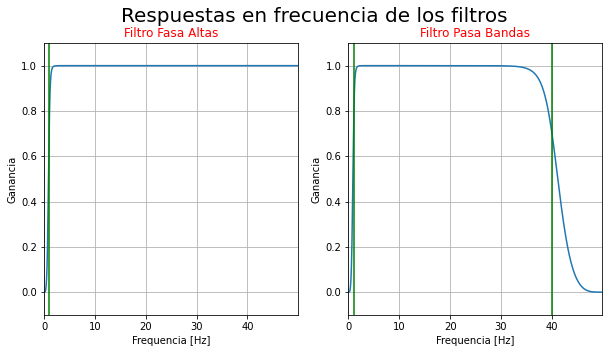

In [ ]:
#Filtrado de señales telesismicas

import scipy.signal as signal
fs = data['fs']
fs = fs[0]
fs = fs[0]
nyq = fs * 0.5

# Filtro pasa altas
cutoff_hz = 1.0
b, a = signal.butter(4, cutoff_hz/nyq, btype="highpass", analog=False) # Filtro pasa altas
w1, h1 = signal.freqz(b, a)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot((fs * 0.5 / np.pi) * w1, abs(h1))
plt.title('Filtro Fasa Altas', color='red')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Ganancia')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(cutoff_hz, color='green') # cutoff frequency

# Filto pasa bandas
cutoff_hz_1 = 1.0
cutoff_hz_2 = 40.0
d, c = signal.butter(4, [cutoff_hz_1/nyq, cutoff_hz_2/nyq] , btype='bandpass', analog=False) # Filtro pasa bandas
w2, h2 = signal.freqz(d, c)
plt.subplot(122)
plt.plot((fs * 0.5 / np.pi) * w2, abs(h2))
plt.title('Filtro Pasa Bandas', color='red')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Ganancia')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(cutoff_hz_1, color='green') # cutoff frequency 1
plt.axvline(cutoff_hz_2, color='green') # cutoff frequency 2
plt.suptitle('Respuestas en frecuencia de los filtros', fontsize=20)

En las 2 gráficas anteriores podemos apreciar la respuesta en frecuencia de loz 2 filtros digitales creados, el primero un filtro pasa altas con frecuencia de corte de 1 Hz como se observa en la linea verde y el segundo un filtro pasabandas cuyas frecuencias de corte son 1 Hz y 40 Hz como se planteo previamente. Tambien se puede observar que cada uno de los filtros tiene ganancia igual a 1, lo que significa que despues de que cada una de las señales sea filtrada a través de este filtro no se tendra ninguna alteración en la amplitud de ninguna de las componentes de la serie. 

In [ ]:
#Filtrado de señales telesismicas

#Matriz de las señales filtradas
Z = np.zeros((21,32000)) 
for i in range(8):    
  filtered_Y = signal.lfilter(b, a, Y[i,:]) 
  Z[i:] = filtered_Y 
for i in range(8,21):    
  filtered_Y = signal.lfilter(d, c, Y[i,:]) 
  Z[i:] = filtered_Y

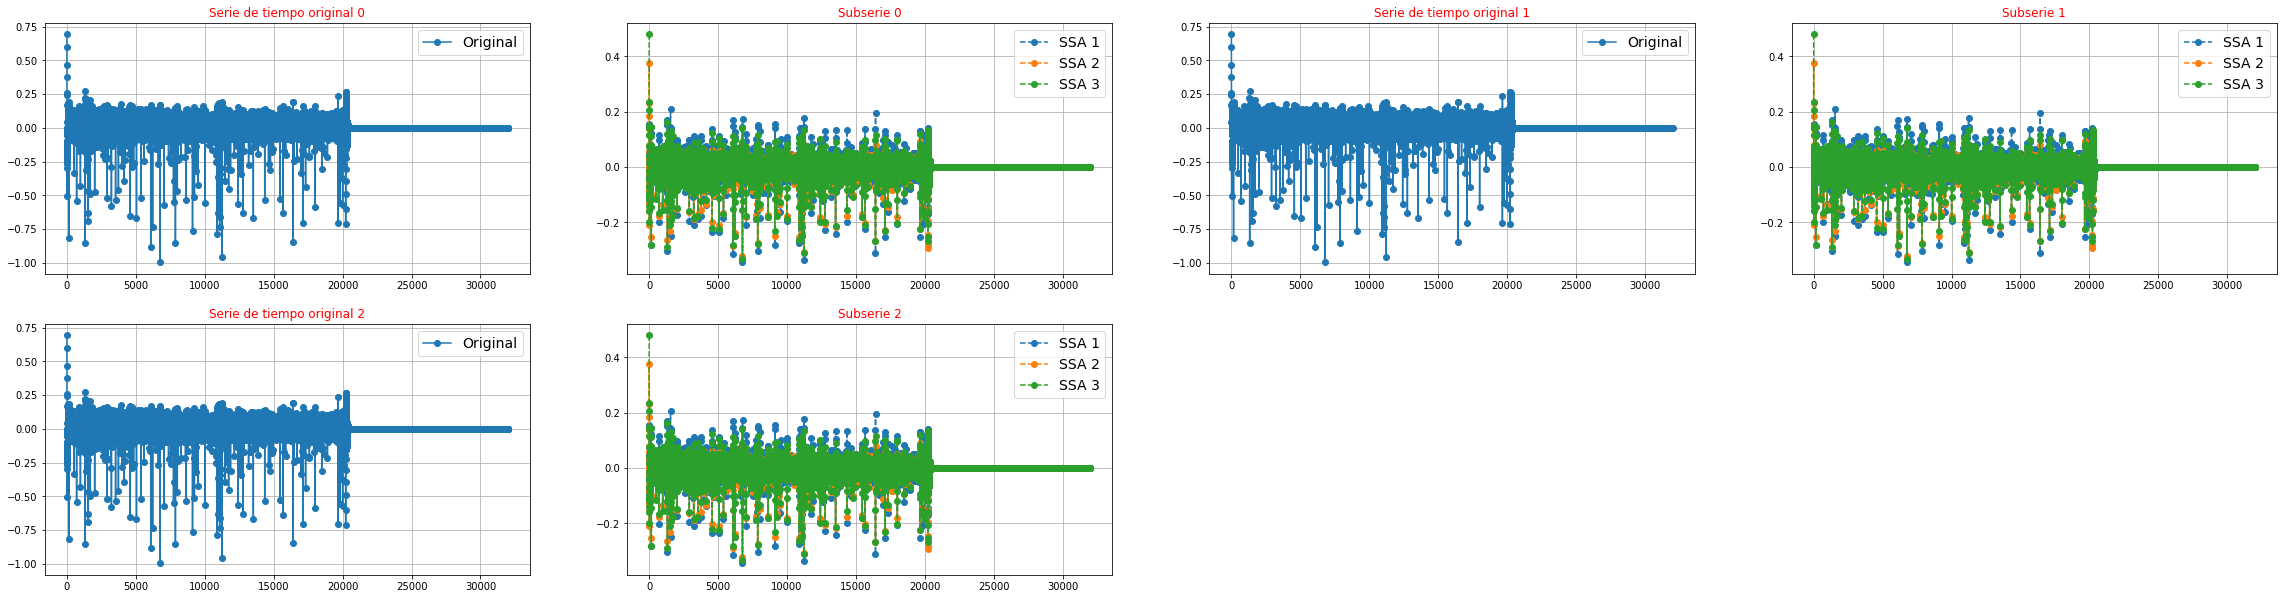

In [ ]:
# Análisis espectro singular
# Se realiza la descomposición de cada una de las serie de tiempo en 3 subseries

X = Z
groups = 3
ssa = SingularSpectrumAnalysis(window_size=groups)
X_ssa = ssa.fit_transform(X)
k=1
for i in range(3):  
  plt.figure(1,figsize=(40, 60))
  idSignal = i
  plt.subplot(11, 4, k)
  plt.plot(X[idSignal], 'o-', label='Original')
  plt.legend(loc='best', fontsize=14)
  plt.title('Serie de tiempo original %i' %i, color="red")
  plt.grid()
  plt.subplot(11, 4, k+1)
  for j in range(groups):
      plt.plot(X_ssa[idSignal, j], 'o--', label='SSA {0}'.format(j + 1))
  plt.legend(loc='best', fontsize=14)
  plt.title('Subserie %i' %i, color="red")
  plt.grid()
  k = k+2

En las imágenes anteriores se realiza la graficación de las 3 primeras señales de telesismos con su respectivas representacion de subseries o representaciones de espectro singular.
En las gráficas anteriores podemos observar las subseries generaron para las primeras 3 señales telesismicas, se logra observar que son segmentos con la misma duracción que su correspondiente señal sin dividir, adicional a esto luego de que la señal fue filtrada se observa como las señales originales ya no tienen ese nivel dc que contenian antes de que fueran filtradas.

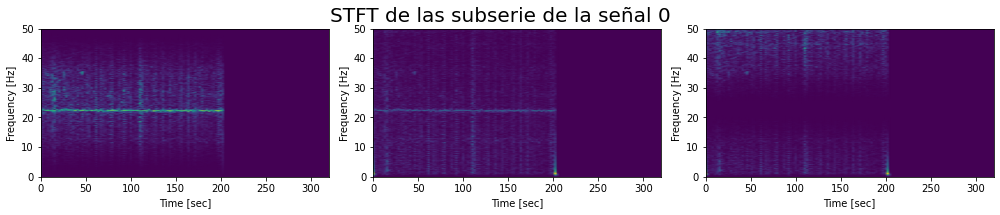

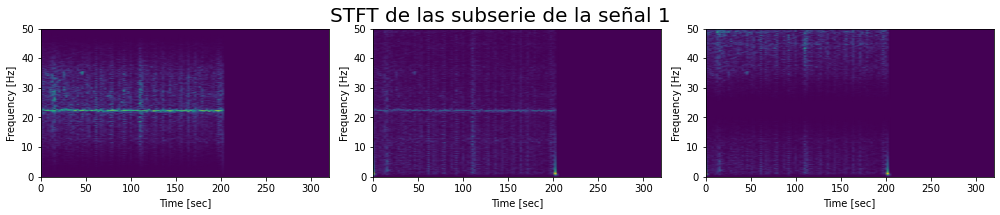

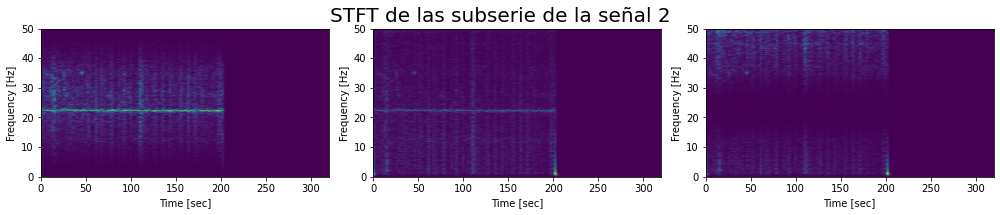

In [ ]:
#Transformada de corto tiempo de Fourier (STFT) de las señales telesísmicas

fs = data['fs']
fs = fs[0]
fs = fs[0]

for i in range(3):
  for j in range(3):
    x = X_ssa[i, j] 
    f, t, Zxx = signal.stft(x, fs, nperseg=512)
    plt.figure(1,figsize=(14, 3))
    plt.subplot(1,3,j+1)
    plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
    #plt.title('STFT Magnitude')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.suptitle('STFT de las subserie de la señal %i' %i, fontsize=20)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
  plt.show()

En la imágen anterior se presentaron la gráfica obtenida de el cálculo de la STFT ó transformada de corto tiempo de Fourier sobre las 3 primeras señales del conjunto de señales telesismicas que se va a analizar.

De la transformada de Fourier de corto tiempo es posible evidenciar que después de la división realizada en el análisis de espectro singular en la primer señal obtenida el espectro se mueve al rededdor de una frecuencia, pero siendo 0 en las frecuencias mas bajas y en las más altas; a medida que nos alejamos de ese valor de frecuencia central la amplitud de las componentes va disminuyendo; en la segunda tambien se distribuye alrededor de una frecuencia central, parecido a como lo hace la subserie anterior, pero con valores menos de amplitud menos intensos y esparciendose dentro de todo el rango posible; y en la última tanto en las frecuencias más altas como en las más bajas. Todo esto para las 3 primeras subseries.

In [ ]:
#Descriptores de las 21 señales telesismicas

L = []
for i in range(21):
  descriptores = []
  for j in range(3):
    x = X_ssa[i, j]   
    f, t, Zxx = signal.stft(x, fs, nperseg=512)
    absZxx = np.abs(Zxx)
    maximos = np.max(absZxx,axis=1)
    energia = maximos.dot(maximos)
    idx_Pot_ord = np.argsort(maximos)
    idx_Pot_ord = idx_Pot_ord[-4:] # las 4 mayores potencias
    Pmax = maximos[idx_Pot_ord]
    fPmax = f[idx_Pot_ord]
    meaP = np.mean(maximos)
    varP = np.var(maximos)
    maxP = np.max(maximos)
    minP = np.min(maximos) 
    descriptores = np.append(descriptores, energia)   
    PmaxfPmax = np.concatenate((Pmax, fPmax))    
    descriptores = np.append(descriptores, PmaxfPmax)
    descriptores = np.append(descriptores, meaP)
    descriptores = np.append(descriptores, varP)
    descriptores = np.append(descriptores, maxP)
    descriptores = np.append(descriptores, minP)
  L.append(descriptores)

Para el cálculo de la energía de la señal se utilizó la siguiente fórmula, pero esta se utilizó sobre el espectro de corto tiempo de Fourier hayado para cada subserie de cada señal:

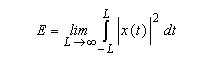

In [ ]:
data2 = sc.loadmat('sisLoc.mat') #Señales de sismos locales  

In [ ]:
#Vectores de señales de sismos locales
Y2 = data2['Y']  
fs2 = data2['fs']

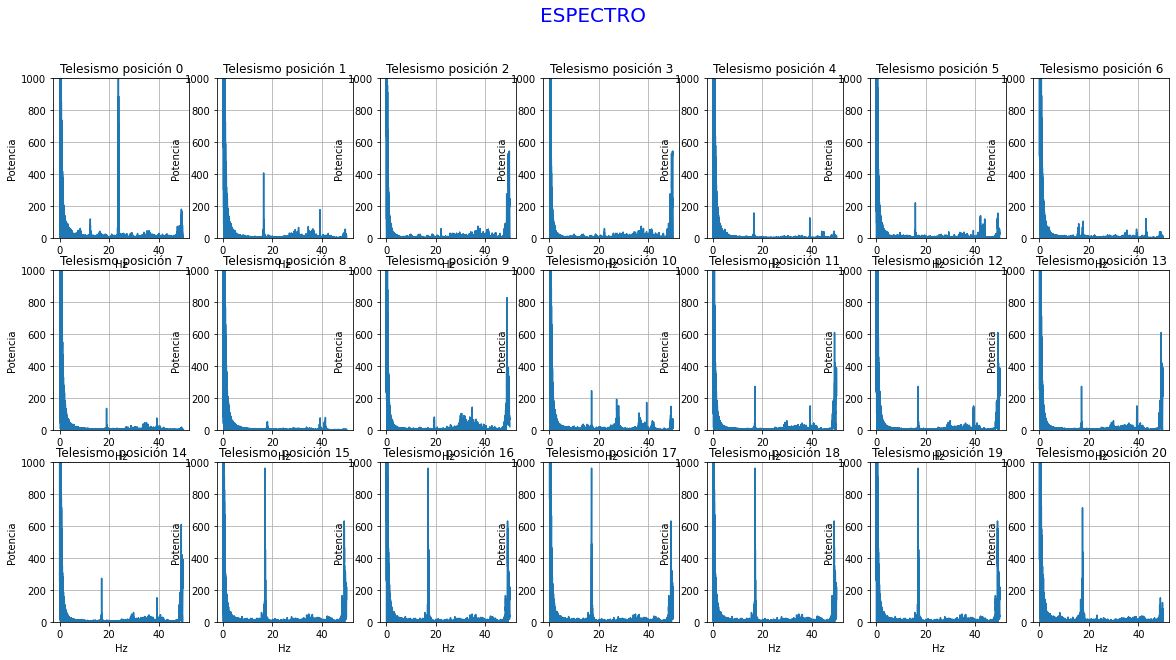

In [ ]:
#Transformadas de fourier de las 21 señales de sismos locales
for i in range(21):
  y= Y2[i,:]
  plt.figure(1,figsize=(20, 10))
  plt.subplot(3, 7, i+1)
  X = np.fft.fft(y)
  X_pow = np.abs(X) ** 2
  N = len(y)
  f_pos = np.arange(0, fs2 / 2, step=fs2 / N)
  plt.plot(f_pos[:-1], X_pow[:(N // 2)])
  plt.ylim([0,1000])
  plt.grid(True)
  plt.xlabel("Hz")
  plt.ylabel("Potencia")
  plt.title("Telesismo posición %i" %i)
  plt.suptitle('ESPECTRO', fontsize=20, color="blue")  

En la gráfica anterior se presentan los espectros de Fourier de las 21 señales de sismos locales. 

En este caso solo se opta por utilizar un filtro pasaaltas para todas las señales estableciendo que la frecuencia de corte va a estar en 1 Hz, unicamente para retirar el nivel dc de la señal

In [ ]:
#Filtrado de las señales de sismos locales

nyq = fs2 * 0.5
cutoff_hz = 1
b, a = signal.butter(4, cutoff_hz/nyq, btype="highpass", analog=False)
Z2 = np.zeros((21,14848))
for i in range(21):  
  filtered_Y = signal.filtfilt(b, a, Y2[i,:]) 
  Z2[i:] = filtered_Y

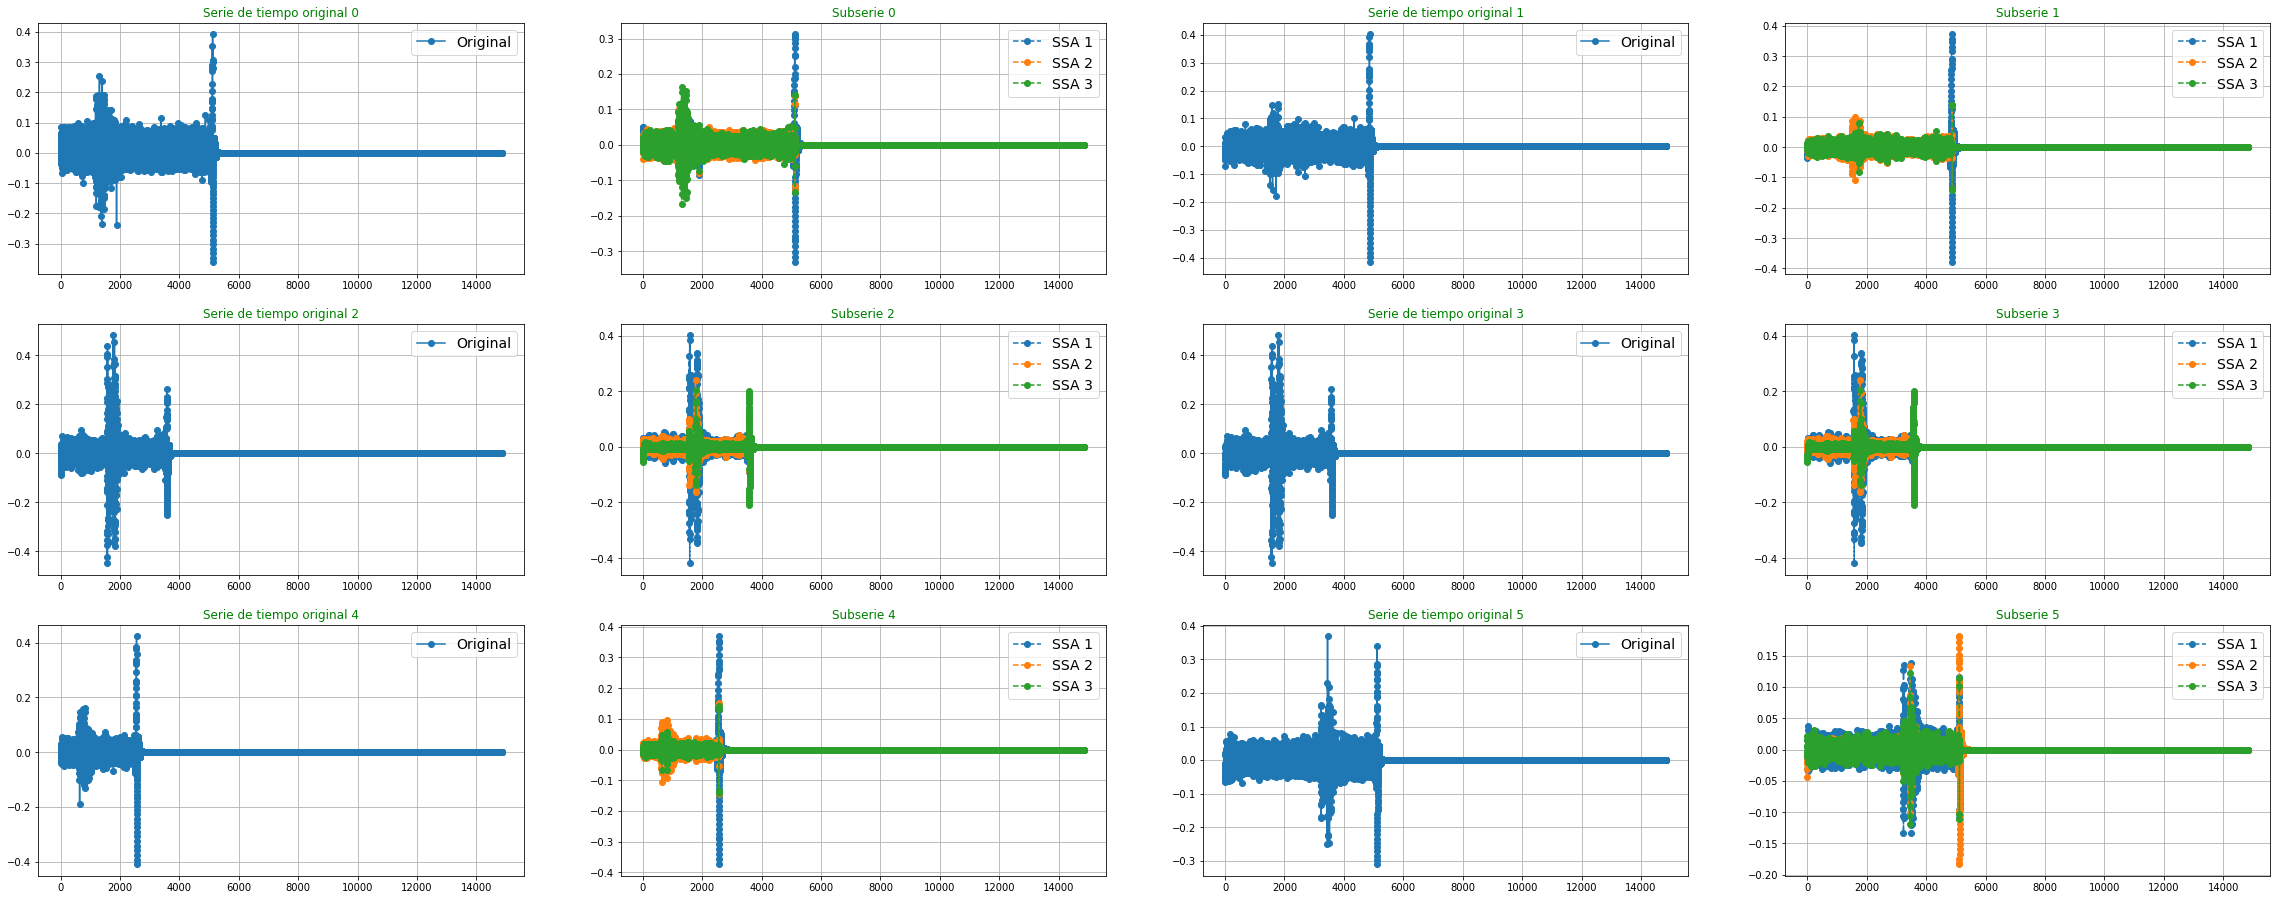

In [ ]:
# Análisis de espectro singular de los sismos locales
# Se realiza la descomposición de cada una de las señales en 3 subseries

X2 = Z2
groups = 3
ssa2 = SingularSpectrumAnalysis(window_size=groups)
X_ssa2 = ssa2.fit_transform(X2)
k=1
for i in range(6):  
  plt.figure(1,figsize=(40, 60))
  idSignal = i
  plt.subplot(11, 4, k)
  plt.plot(X2[idSignal], 'o-', label='Original')
  plt.legend(loc='best', fontsize=14)
  plt.title('Serie de tiempo original %i' %i, color="green")
  plt.grid()
  plt.subplot(11, 4, k+1)
  for j in range(groups):
      plt.plot(X_ssa2[idSignal, j], 'o--', label='SSA {0}'.format(j + 1))
  plt.legend(loc='best', fontsize=14)
  plt.title('Subserie %i' %i, color="green")
  plt.grid()
  k = k+2

En la imagén anterior se graficó el espectro singular de las 6 primeras señales de sismos locales, colocando cada grupo de subseries obtenidas de el análisis en un subplot, posterior a la colocación de la gráfica de la señal original.

Del análisis de espectro singular para las señales de sismos locales se puede observar que las señales estan superpuestas de forma tal que se alcanza a apreciar que la primer señal generada de la división contiene el segmento cuyos valores de amplitud rebasan a los demás en aproximadamente un orden de magnitud, mientras que los otros no contienen este mismo patron, para las demas discrepancias que aparecen en la señal original, se observa que todas las señales obtenidas del análisis del espectro singular contienen patrones similares

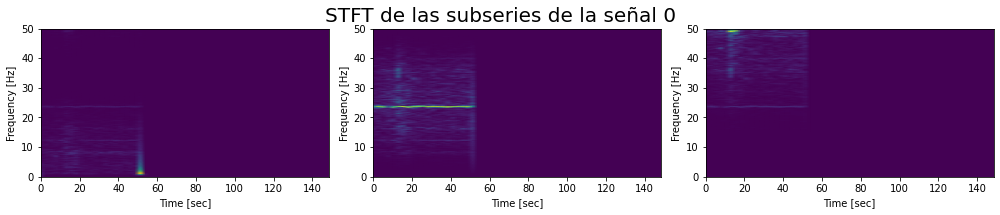

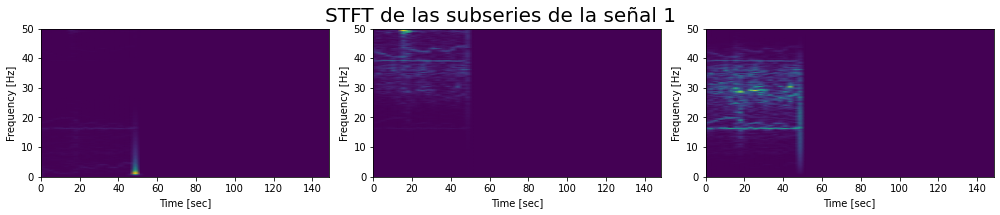

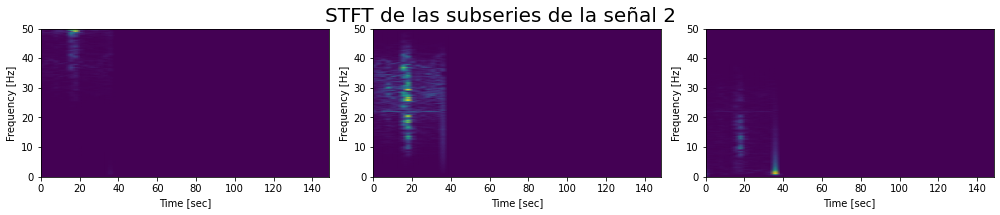

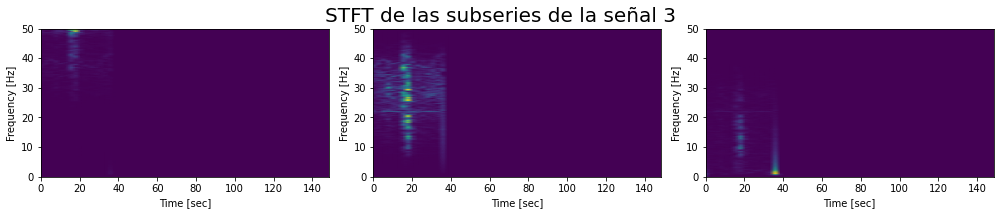

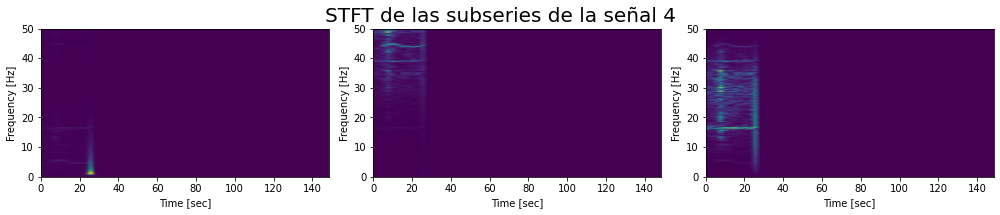

In [ ]:
#Transformada de corto tiempo de Fourier de las subseries de los sismos locales

fs2 = data2['fs']
fs2 = fs2[0]
fs2 = fs2[0]

for i in range(5):
  for j in range(3):
    x2 = X_ssa2[i, j] 
    f2, t2, Zxx2 = signal.stft(x2, fs2, nperseg=512)
    plt.figure(1,figsize=(14, 3))
    plt.subplot(1,3,j+1)
    plt.pcolormesh(t2, f2, np.abs(Zxx2), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.suptitle('STFT de las subseries de la señal %i' %i, fontsize=20)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
  plt.show()

En la imagén anterior se presenta la transformada de tiempo corto de Fourier de las primeras 5 señales de sismos locales. 

En este caso se observa que el espectro varia en su comportamiento para cada una de ellas, en la primer subserie de la señal 1 este esta cerca de las bajas frecuencias, en el tiempo 50 segundos se observa un fuerte intensidad contrario a todos los otros instantes de tiempo; en la segunda subserie el espectro se distribuye en las altas frecuencias dentro de un rango equivalente al rango de frecuencias de la señal original, siendo más o menos la frecuencia en 24 Hz la componente que presenta la mayor intensidad a través de todo el tiempo; en la tercera la potencia se distribuye en las frecuencias más altas, presentandose una región de mayor intensidad entre los 14 y 18 segundos para la frecuencia de 50 Hz. Para la primer subserie de la segunda señal este aparece de forma similar a como aparece para la señal 1, en la segunda subserie concentrado en las frecuencias más altas y con un punto de máxima potencia entre los 14 y 18 segundos para la frecuencia de 50 Hz y en la ultima subserie la potencia se distribuye en todas las frecuencias pero de forma intermitente a tráves del tiempo. Se observan regiones de mayor potencia para cada uno de los otros espectros gráficados.

In [ ]:
# Descriptores de las señales de sismos locales

for i in range(21):
  descriptores2 = []
  for j in range(3):
    x2 = X_ssa2[i, j]   
    f2, t2, Zxx2 = signal.stft(x2, fs2, nperseg=512)
    absZxx2 = np.abs(Zxx2)
    maximos2 = np.max(absZxx2,axis=1)
    energia2 = maximos2.dot(maximos2)
    idx_Pot_ord2 = np.argsort(maximos2)
    idx_Pot_ord2 = idx_Pot_ord2[-4:] # las 4 mayores potencias
    Pmax2 = maximos2[idx_Pot_ord2]
    fPmax2 = f2[idx_Pot_ord2]
    meaP2 = np.mean(maximos2)
    varP2 = np.var(maximos2)
    maxP2 = np.max(maximos2)
    minP2 = np.min(maximos2) 
    descriptores2 = np.append(descriptores2, energia2)   
    PmaxfPmax2 = np.concatenate((Pmax2, fPmax2))    
    descriptores2 = np.append(descriptores2, PmaxfPmax2)
    descriptores2 = np.append(descriptores2, meaP2)
    descriptores2 = np.append(descriptores2, varP2)
    descriptores2 = np.append(descriptores2, maxP2)
    descriptores2 = np.append(descriptores2, minP2)
  L.append(descriptores2)

In [ ]:
data3 = sc.loadmat('sisReg.mat') # Señales de sismos regionales

In [ ]:
# Vectores de señales de sismos regionales
Y3 = data3['Y']  
fs3 = data3['fs']

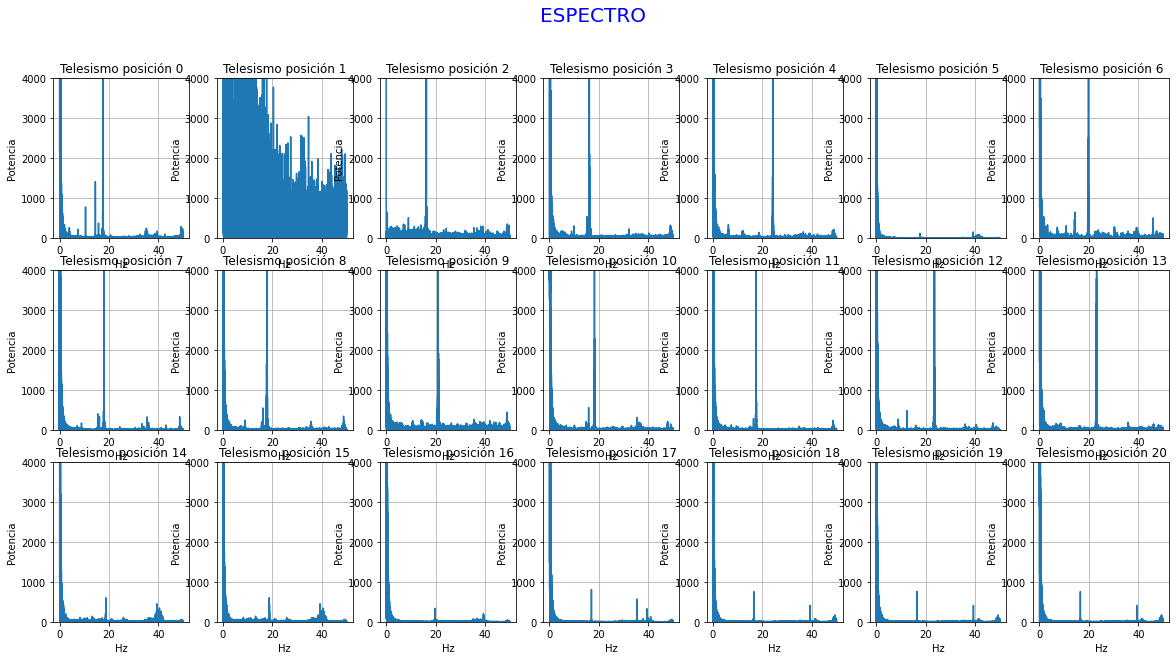

In [ ]:
# Transformadas de fourier de las 21 señales de sismos regionales 
for i in range(21):
  y= Y3[i,:]
  plt.figure(1,figsize=(20, 10))
  plt.subplot(3, 7, i+1)
  X = np.fft.fft(y)
  X_pow = np.abs(X) ** 2
  N = len(y)
  f_pos = np.arange(0, fs / 2, step=fs / N)
  plt.plot(f_pos, X_pow[:(N // 2)])
  plt.ylim([0,4000])
  plt.grid(True)
  plt.xlabel("Hz")
  plt.ylabel("Potencia")
  plt.title("Telesismo posición %i" %i)
  plt.suptitle('ESPECTRO', fontsize=20, color="blue")  

En la imagén anterior se presentan las espectroso de Fourier de el conjunto de datos que corresponden a 21 señales de sismos regionales.

En este caso se opta por la decisión de utilizar nuevamente un filtro que elimine la frecuencia de 0 Hz que corresponde a un desplazamiento que esta teniendo la señal alrededor del eje vertical.

In [ ]:
#Filtrado de las señales de sismos regionales

nyq = fs3 * 0.5
cutoff_hz = 1 #La frecuencia de corte seleccionada es de 1 Hz
b, a = signal.butter(4, cutoff_hz/nyq, btype="highpass", analog=False)
Z3 = np.zeros((21,30720))
for i in range(21):  
  filtered_Y = signal.filtfilt(b, a, Y3[i,:]) 
  Z3[i:] = filtered_Y #Z3 es la matriz de las señales de sismos regionales filtradas

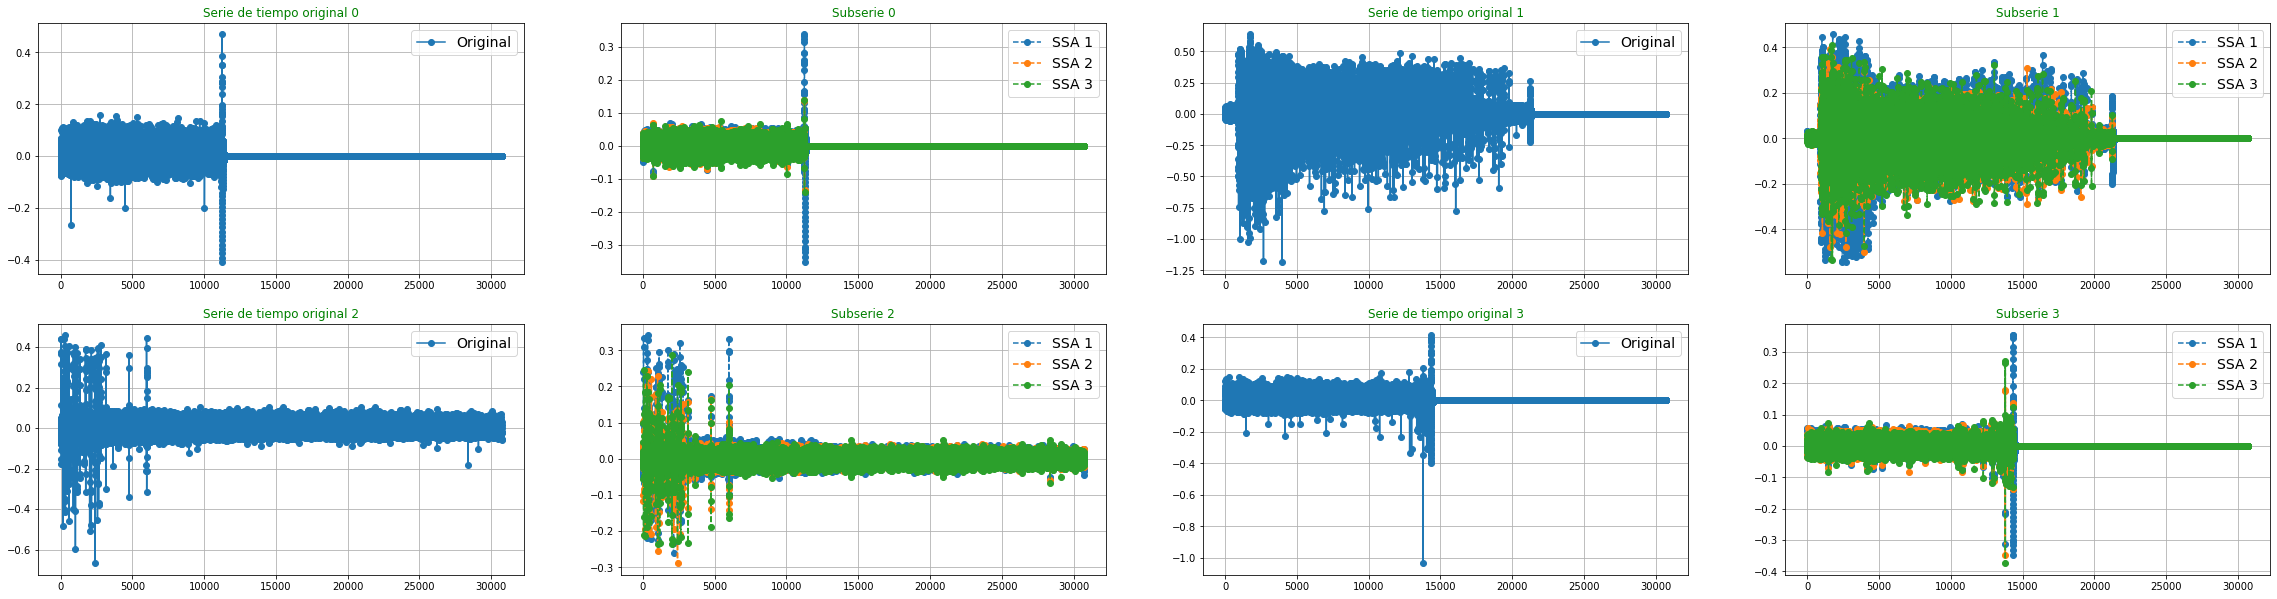

In [ ]:
# Análisis de espectro singular de los sismos regionales
# Se descompone las series de tiempo en 3 subseries

X3 = Z3
groups = 3
ssa3 = SingularSpectrumAnalysis(window_size=groups)
X_ssa3 = ssa3.fit_transform(X3)
k=1

for i in range(4):  
  plt.figure(1,figsize=(40, 60))
  idSignal = i
  plt.subplot(11, 4, k)
  plt.plot(X3[idSignal], 'o-', label='Original')
  plt.legend(loc='best', fontsize=14)
  plt.title('Serie de tiempo original %i' %i, color= "green")
  plt.grid()
  plt.subplot(11, 4, k+1)
  for j in range(groups):
      plt.plot(X_ssa3[idSignal, j], 'o--', label='SSA {0}'.format(j + 1))
  plt.legend(loc='best', fontsize=14)
  plt.title('Subserie %i' %i, color= "green")
  plt.grid()
  k = k+2

En la imagén anterior se presentaron las divisiones de la señal en sus equivalentes espectros singulares, la división se hace para las primeras 4 señales del conjunto de señales de sismos regionales, esta división sigue presentando los mismos patrones que las divisiones realizadas de forma previa para los otros 2 grupos se señales, siempre se selecciona valor de 3 divisiones y como resultado se observa una señal casí que igual a la señal original y otras 2 señales que pareciera que fueran componentes de ruido que pertenecian a la señal original. La señal verde es la que se asemeja enormemente a la señal original y las amarilla y azul son las que se asemejan a ruido de las señales.

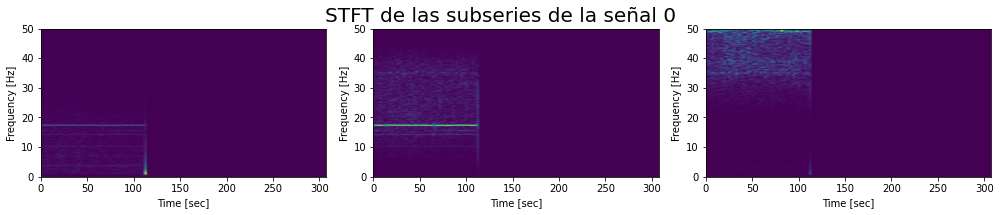

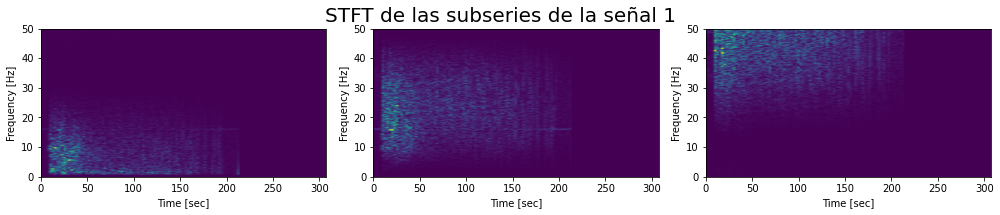

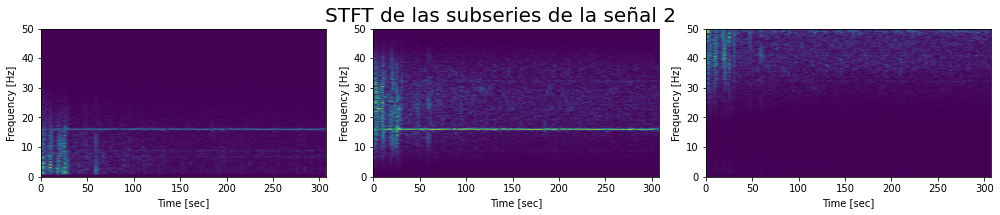

In [ ]:
# Transformada de corto tiempo de Fourier de las subseries de las señales de sismos regionales

fs3 = data3['fs']
fs3 = fs3[0]
fs3 = fs3[0]

for i in range(3):
  for j in range(3):
    x3 = X_ssa3[i, j] 
    f3, t3, Zxx3 = signal.stft(x3, fs3, nperseg=512)
    plt.figure(1,figsize=(14, 3))
    plt.subplot(1,3,j+1)
    plt.pcolormesh(t3, f3, np.abs(Zxx3), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.suptitle('STFT de las subseries de la señal %i' %i, fontsize=20)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
  plt.show()

En la imagen anterior se presentan las transformadas de corto de tiempo de Fourier de la division en espectro singular de 3 señales telesísmicas.

En este caso los espectros aparecen de forma mucho mas difuminada que en los otros 2 grupos, algunas veces se concentran en las bajas frecuencias, otras en las altas y otras al rededor de una frecuencia intermedia.

In [ ]:
#Descriptores de las señales de sismos regionales

for i in range(21):
  descriptores3 = []
  for j in range(3):
    x3 = X_ssa3[i, j]   
    f3, t3, Zxx3 = signal.stft(x3, fs3, nperseg=512)
    absZxx3 = np.abs(Zxx3)
    maximos3 = np.max(absZxx3,axis=1)
    energia3 = maximos3.dot(maximos3)
    idx_Pot_ord3 = np.argsort(maximos3)
    idx_Pot_ord3 = idx_Pot_ord3[-4:] # las 4 mayores potencias
    Pmax3 = maximos3[idx_Pot_ord3]
    fPmax3 = f3[idx_Pot_ord3]
    meaP3 = np.mean(maximos3)
    varP3 = np.var(maximos3)
    maxP3 = np.max(maximos3)
    minP3 = np.min(maximos3) 
    descriptores3 = np.append(descriptores3, energia3)   
    PmaxfPmax3 = np.concatenate((Pmax3, fPmax3))    
    descriptores3 = np.append(descriptores3, PmaxfPmax3)
    descriptores3 = np.append(descriptores3, meaP3)
    descriptores3 = np.append(descriptores3, varP3)
    descriptores3 = np.append(descriptores3, maxP3)
    descriptores3 = np.append(descriptores3, minP3)
  L.append(descriptores3)

In [ ]:
# Creacion de dataframe con el recurso L que corresponde a la matriz de descriptores de todas las señales
import pandas as pd
df = pd.DataFrame(L,columns=['Energia_1','PMax_1','PMax_2','PMax_3','PMax_4','F_Pmax_1','F_Pmax_2','F_Pmax_3','F_Pmax_4','Media_1','Var_1','Max_1','Min_1', 'Energia_2','PMax_5','PMax_6','PMax_7','PMax_8','F_Pmax_5','F_Pmax_6','F_Pmax_7','F_Pmax_8','Media_2','Var_2','Max_2','Min_2', 'Energia_3','PMax_9','PMax_10','PMax_11','PMax_12','F_Pmax_9','F_Pmax_10','F_Pmax_11','F_Pmax_12','Media_3','Var_3','Max_3','Min_3'])

In [ ]:
# Creación de la columna de etiquetas para la matriz de descriptores
L1 = 'Telesismo'
L2 = 'Local'
L3 = 'Regional'

vL1 = np.tile(L1,21)
vL2 = np.tile(L2,21)
vL3 = np.tile(L3,21)

df['Etiquetas'] = np.concatenate((vL1,vL2,vL3),axis = 0)

In [ ]:
df

Energia_1    PMax_1    PMax_2  ...     Max_3     Min_3  Etiquetas
0    0.003329  0.008261  0.010778  ...  0.017054  0.000108  Telesismo
1    0.003329  0.008261  0.010778  ...  0.017054  0.000108  Telesismo
2    0.003329  0.008261  0.010778  ...  0.017054  0.000108  Telesismo
3    0.003329  0.008261  0.010778  ...  0.017054  0.000108  Telesismo
4    0.003329  0.008261  0.010778  ...  0.017054  0.000108  Telesismo
..        ...       ...       ...  ...       ...       ...        ...
58   0.011755  0.030492  0.033136  ...  0.006060  0.000034   Regional
59   0.010646  0.029123  0.032053  ...  0.003871  0.000049   Regional
60   0.007241  0.023877  0.026246  ...  0.003723  0.000037   Regional
61   0.007241  0.023877  0.026246  ...  0.003723  0.000037   Regional
62   0.007241  0.023877  0.026246  ...  0.003723  0.000037   Regional

[63 rows x 40 columns]

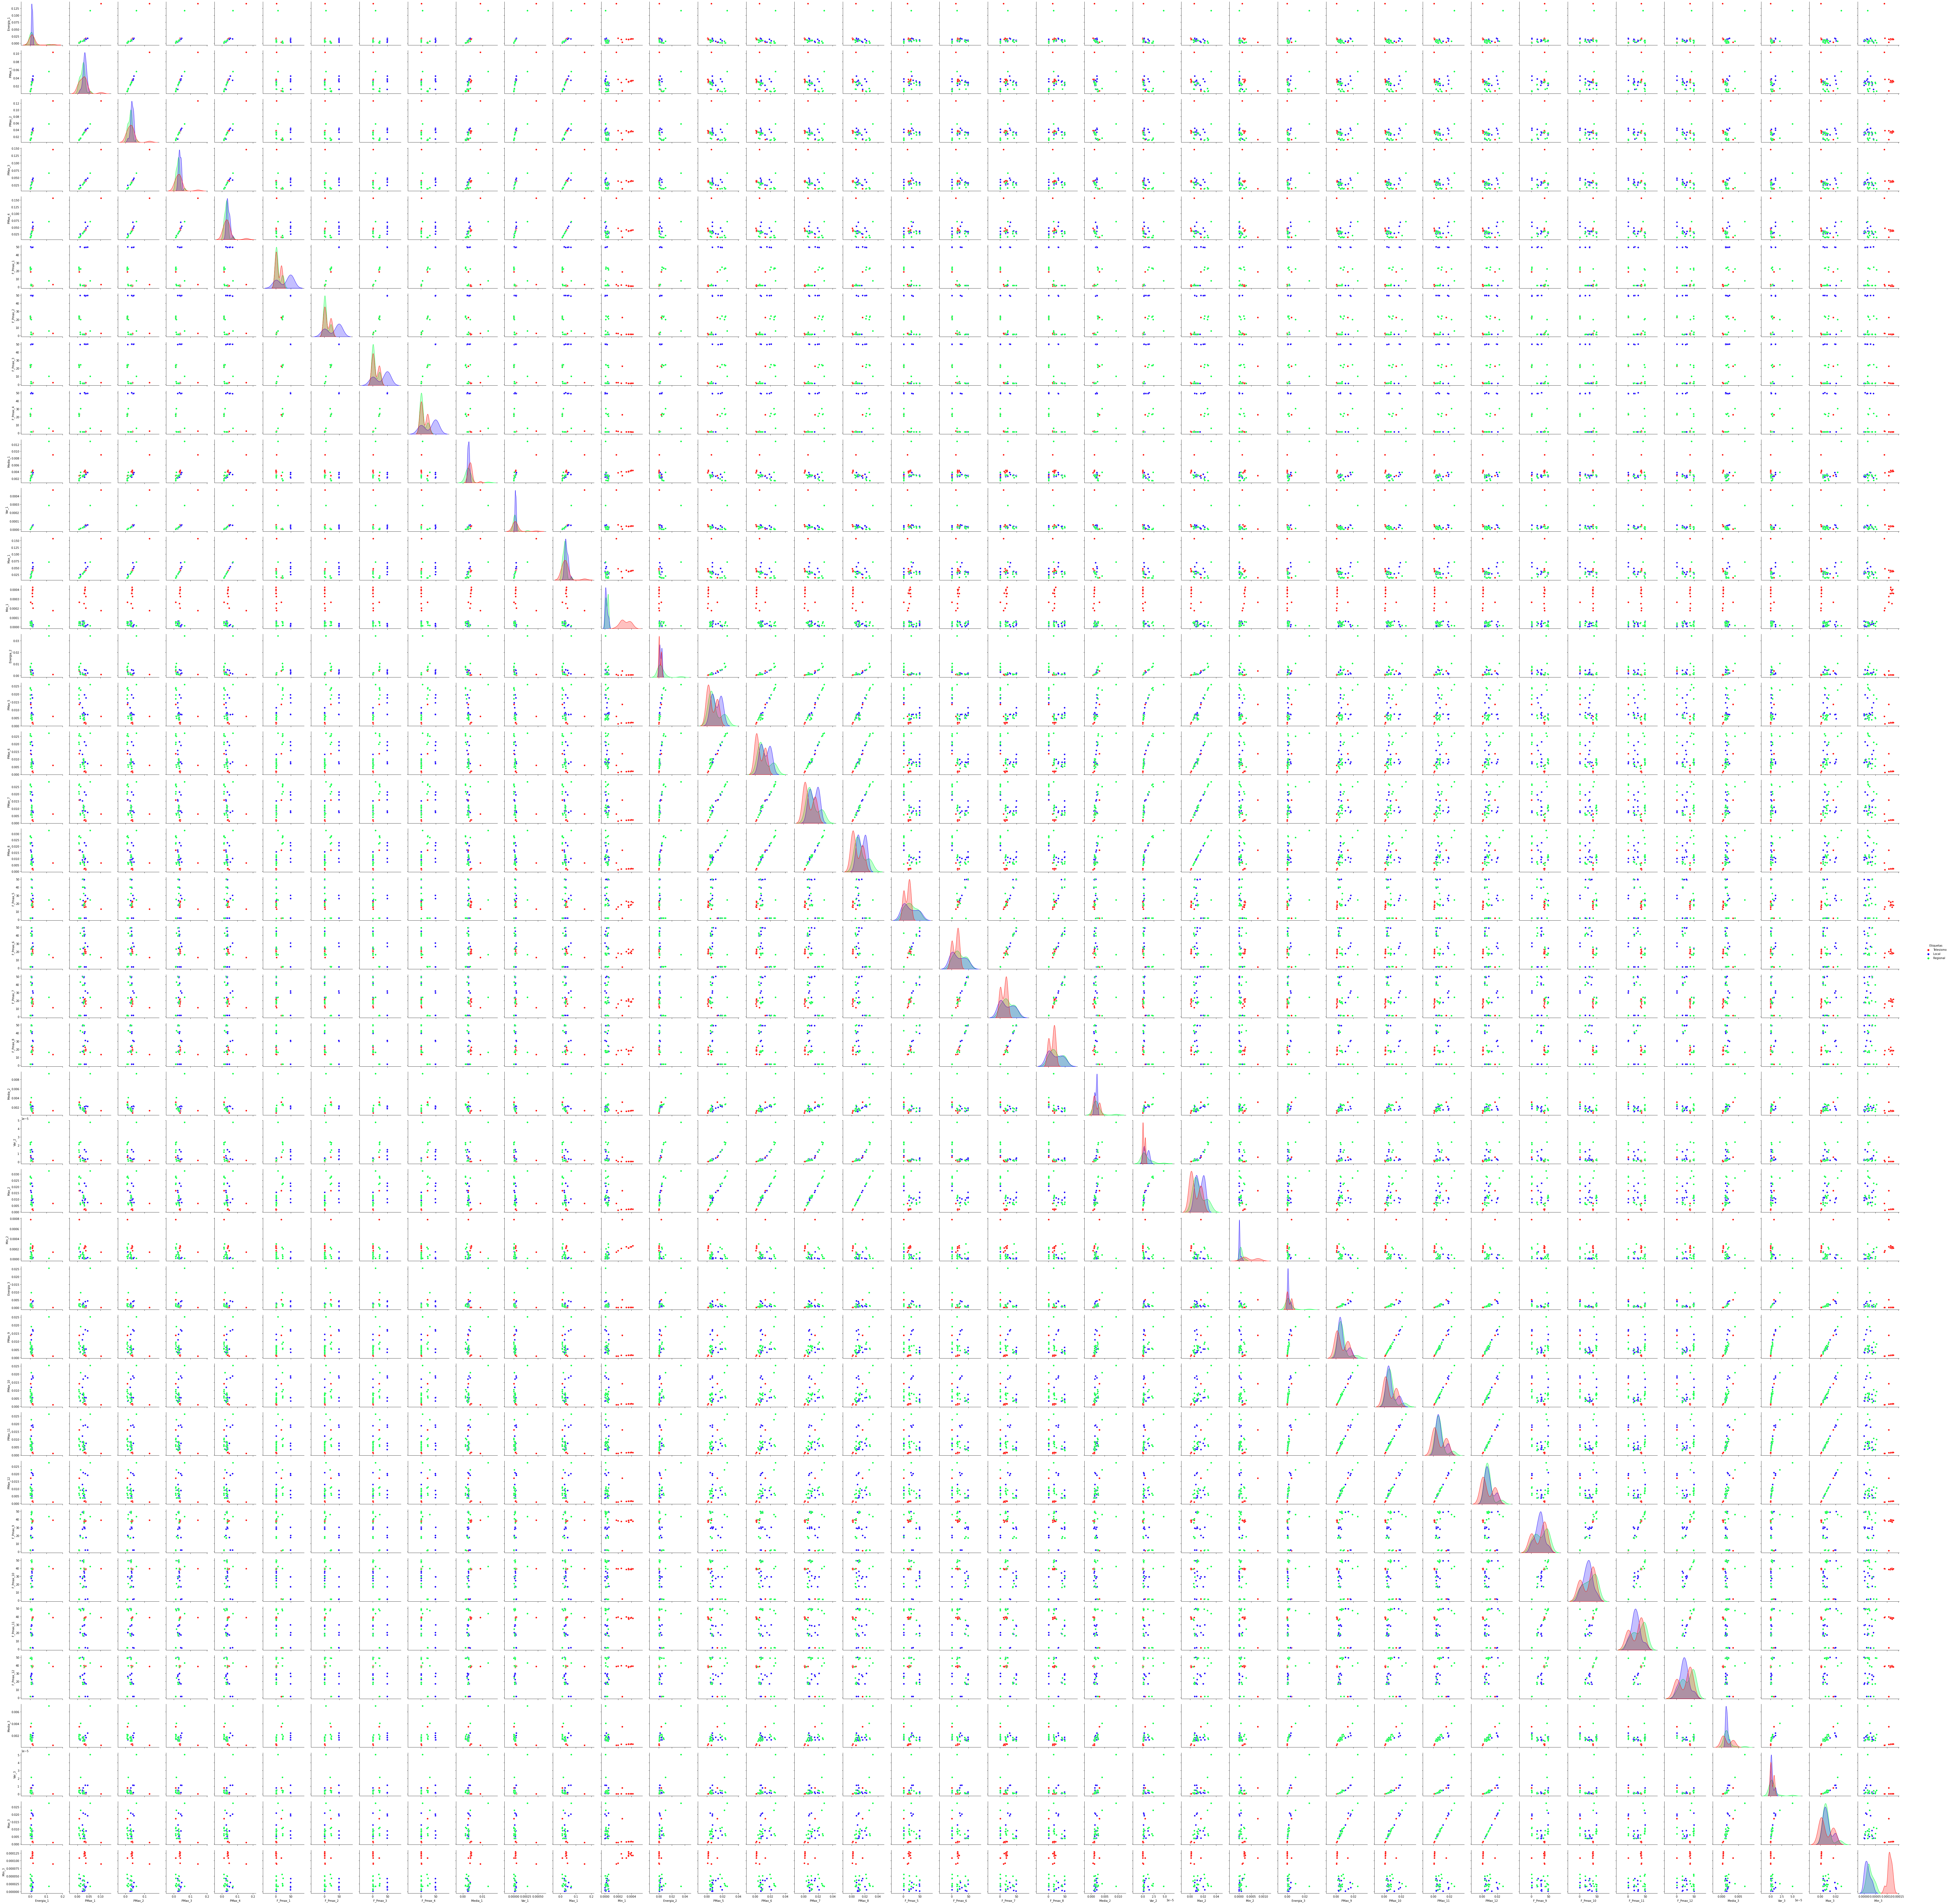

In [ ]:
import seaborn as sns
# Create an array with the colors you want to use
colors = ["#FF0B04", "#1500ff", "#00ff3c"]
sns.pairplot(df, hue="Etiquetas", height = 2.5 , palette=colors)

**Nota:** para observar las gráficas de cerca se debe de dar un click izquierdo con el mouse sobre ellas

# Observaciones y/o conclusiones:
-De los datos obtenidos se logra evidenciar que estos se encuentran un poco mezclados entre si, es decir no se logra establecer un frontera que separe las 3 nubes de puntos que corresponden a los grupos de sismos los cualés fueron sujetos de procesamiento, por lo tanto no es posible clasificar los 3 grupos de sismos de forma apropiada con ninguno de los descriptores calculados

-Para visualizar de forma apropiada la descrito anteriormente se presenta la siguiente imagen:

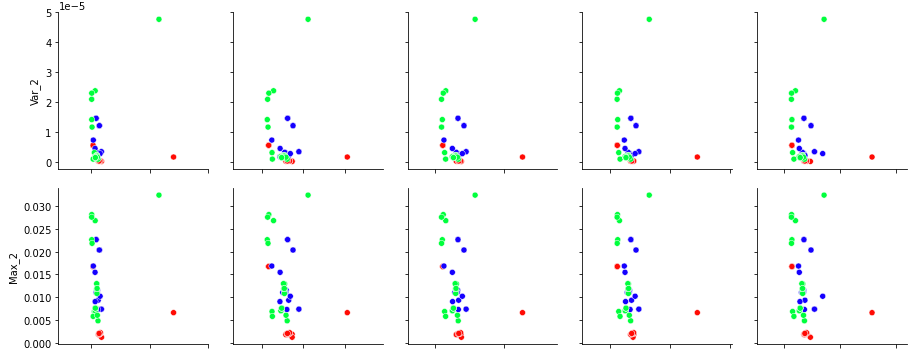

Para el descriptor de potencia máxima 2 y de varianza vs los primeros 4 desciptores calculados no se logra realizar una separacion adecuada entre ellos

-Aunque para algunas parejas de descriptores se alcanza a notar una buena separación entre las nubes de puntos de los 3 grupos de señales, un caso de estos seria cuando se gráfica el mínimo 1 vs la potencia máxima 1, el mínimo 1 vs la potencia máxima 2 y el mínimo 1 vs la potencia máxima 3 como se observa en la siguiente imagen:

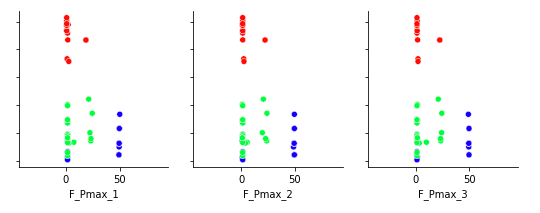

-Se observa que las caracteristicas calculadas para las señales de telesismos representan adecuadamente a este grupo ya que las nubes de  puntos rojos que corresponden a las caracterisiticas de estos sismos se ubican en una región en la cual no se ubica ninguna caracteristica de los otros 2 grupos de sismos existentes, un ejemplo seria las gráficas siguientes:

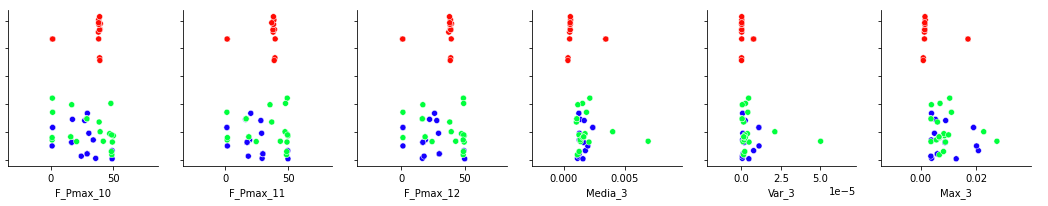

-Para ciertas caracteristicas los datos se presentan de forma muy lineal, no se tiene seguridad si fue por algún error en el cálculo de las operaciones o en la escritura del código, o es un comportamiento normal de este tipo de análisis, a continuación presentamos algunos ejemplos:

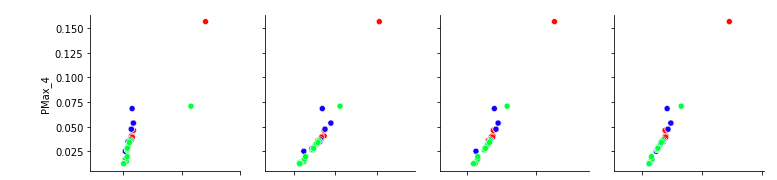

-Dentro de cada una de las gráficas se evidencian comportamientos particulares como que no aparecen todos los puntos o descriptores calculados para la caracterisitca especifica dentro de estas, es decir si se calculan 63 descriptores de energía, los cuáles se encuentran dentro del dataframe final y luego se calculan 63 descriptores de potencia máxima 1, debieran de aparecer 63 puntos total en una gráfica energía vs potencia máxima 1, lo cual no sucede. La razón podria ser porque tal vez algunos puntos se solapan con otros generando así dicha impresión, esto se puede visualizar en las imágenes anteriores.

-La aparición de los datos para cada uno de los grupos de señales varian en rangos, algunas veces los rangos para un desriptor son rangos más amplios para un grupo de señal que para otro, en otras ocasiones son rangos similares y en otras ocasiones los rangos de 2 grupos son similares pero difieren completamente con el tercer grupo, en la  siguiente gráfica se muestran algunos patrones de comportamiento, los cuales corresponden a los patrones de potencia máxima 7, 8 y la frecuencia de la potencia máxima 5:

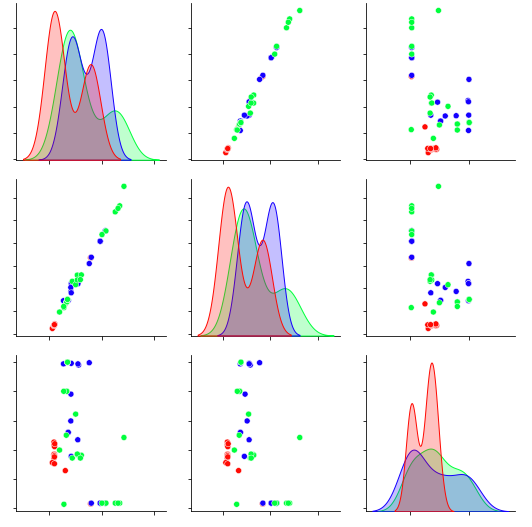

-Los histogramas gráficados en la diagonal principal no generan una caracterización muy apropiada de los grupos de sismos, ya que por lo general, los datos se concentran para cada uno de los descriptores de los 3 grupos de selales en rangos equivalentes, lo que en parte esta diciendo que los datos posiblemente se van a mezclar cuando se realicen la gráfica de pares, para ello presentamos la siguiente gráfica:

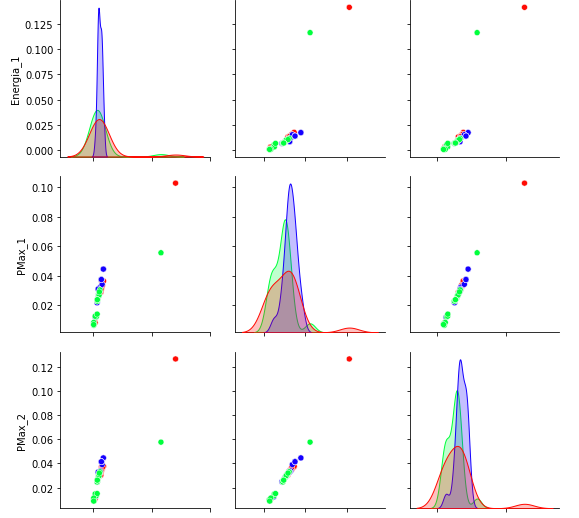

-En algunos descriptores uno de los grupos de datos se separan completamente de los otros como en el descriptor del mínimo de potencia:

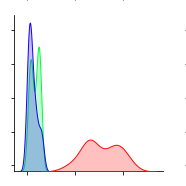






-Se podría realizar una normalización de los datos ya que tal vez de esta forma se logre evidenciar una mejor división de los datos, la cual no se logra apreciar por la cercania de los datos entre sí

-En algunas ocasiones los datos de ciertos grupos de señales se encuentran muy cercanos entre si mientras que en los demas grupos se dispersan más, y en otras ocasiones se evidencias distanciamentos entre los puntos similares para los 3 grupos de sismos: